In [1]:
from datetime import date, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from basketball_reference_web_scraper import client
from basketball_reference_web_scraper.data import Location, Team
from basketball_reference_web_scraper.data import TEAM_TO_TEAM_ABBREVIATION as TEAM2ABRV

Ties:  6
Lead changes:  19
Biggest lead:  10
LAC leading:  13:40
DAL leading:  31:36


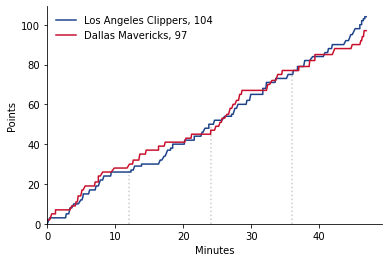

In [23]:
def analyse_game(home_team, year, month, day):
    scores = pd.DataFrame(
        client.play_by_play(home_team=home_team, year=year, month=month, day=day)
    )

    print(
        "Ties: ", 
        scores.drop_duplicates(subset=["away_score", "home_score"]).eval("away_score == home_score").sum(),
    )
    print(
        "Lead changes: ",
        (scores.eval("away_score - home_score").replace(0, np.nan).dropna() < 0).diff().sum(),
    )
    print(
        "Biggest lead: ",
        scores.eval("away_score - home_score").abs().max(),
    )

    scores["time"] = (
        np.minimum(scores["remaining_seconds_in_period"].diff(), 0).cumsum().fillna(0)
        / -60
    )
    scores["duration"] = scores["time"].diff().fillna(0)

    away_lead = pd.to_timedelta(scores.query("away_score > home_score")["duration"].sum(), unit="min")
    print(
        f"{TEAM2ABRV[scores['away_team'][0]]} leading: ",
        f"{away_lead.components.minutes}:{away_lead.components.seconds:02d}",
    )
    home_lead = pd.to_timedelta(scores.query("away_score < home_score")["duration"].sum(), unit="min")
    print(
        f"{TEAM2ABRV[scores['home_team'][0]]} leading: ",
        f"{home_lead.components.minutes}:{home_lead.components.seconds:02d}",
    )
    

    for location, color in {"away": "#1d428a", "home": "#c8102e"}.items():
        team = scores[f"{location}_team"][0]
        name = team.name.title().replace("_", " ")
        score = scores[f"{location}_score"].max()
        plt.plot(
            scores["time"], scores[f"{location}_score"], label=name + ", " + str(score), color=color
        )

    pauses = [
        pause
        for pause in [12, 24, 36, 48, 53, 58, 63, 68, 73, 78, 83]
        if pause < scores["time"].max()
    ]
    pause_scores = [
        scores.query(f"time < {pause}")[["home_score", "away_score"]].max().max()
        for pause in pauses
    ]
    plt.vlines(pauses, 0, pause_scores, colors="0.8", linestyles=":")

    plt.legend(frameon=False)
    plt.xlabel("Minutes")
    plt.ylabel("Points")
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    sns.despine()
    plt.savefig("descht.png")
    plt.show()


analyse_game(home_team=Team.DALLAS_MAVERICKS, year=2021, month=6, day=4)

Ties:  0
Lead changes:  0
Biggest lead:  29
PHO leading:  46:28
LAL leading:  0:00


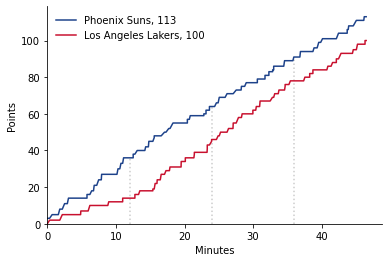

In [3]:
analyse_game(home_team=Team.LOS_ANGELES_LAKERS, year=2021, month=6, day=3)

Ties:  9
Lead changes:  9
Biggest lead:  14
DEN leading:  9:06
POR leading:  34:54


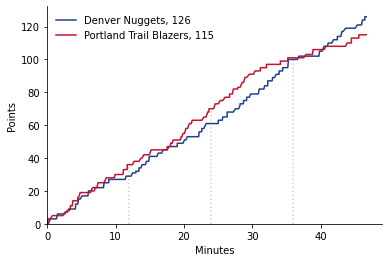

In [4]:
analyse_game(home_team=Team.PORTLAND_TRAIL_BLAZERS, year=2021, month=6, day=3)

Ties:  11
Lead changes:  12
Biggest lead:  22
POR leading:  6:21
DEN leading:  45:46


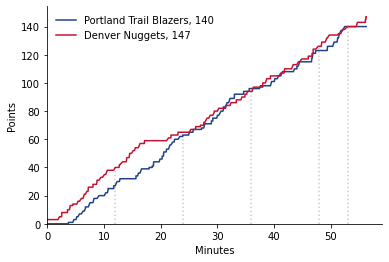

In [5]:
analyse_game(home_team=Team.DENVER_NUGGETS, year=2021, month=6, day=1)

In [6]:
# https://docs.tweepy.org/en/stable/api.html#API.media_upload

In [39]:
"asdf {02d}".format(1)

KeyError: '02d'

#PHOvsLAL 113:100 on 2021-06-03
Ties:  0
Lead changes:  0
Biggest lead:  29
PHO leading:  46:28
LAL leading:  0:00


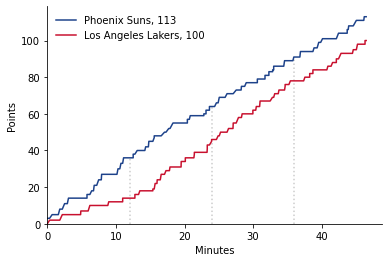

FG: 37 of 73 / 38 of 91
3P: 18 of 35 / 10 of 35
FT: 21 of 22 / 14 of 16
DRB: 34 of 45 / 24 of 32
AST: 24 / 21
STL: 5 / 5
BLK: 9 / 3
TOV: 12 / 7
PF: 17 / 20

Points:  D. Booker 47, L. James 29, D. Schröder 20
Rebounds:  D. Booker 11, L. James 9, J. Crowder 8
Assists:  C. Paul 12, M. Gasol 7, L. James 7
Steals:  C. Johnson 2, M. Bridges 2, L. James 2
Blocks:  C. Payne 3, J. Crowder 2, L. James 2

#DENvsPOR 126:115 on 2021-06-03
Ties:  9
Lead changes:  9
Biggest lead:  14
DEN leading:  9:06
POR leading:  34:54


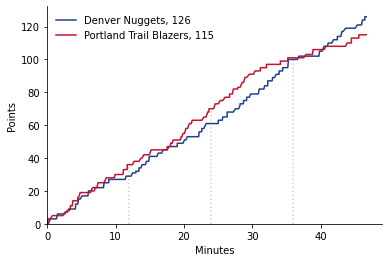

FG: 44 of 86 / 40 of 79
3P: 15 of 34 / 15 of 36
FT: 23 of 27 / 20 of 22
DRB: 29 of 37 / 29 of 39
AST: 28 / 24
STL: 8 / 7
BLK: 3 / 7
TOV: 12 / 16
PF: 18 / 22

Points:  N. Jokić 36, D. Lillard 28, M. Porter 26
Rebounds:  R. Covington 10, J. Green 9, N. Jokić 8
Assists:  D. Lillard 13, M. Morris 9, N. Jokić 6
Steals:  M. Morris 3, R. Covington 3, D. Lillard 2
Blocks:  J. Nurkić 2, F. Campazzo 1, A. Gordon 1



In [7]:
def plot_games_of_day(date=date.today()):
    player_scores = pd.DataFrame(
        client.player_box_scores(year=date.year, month=date.month, day=date.day)
    )
    player_scores["name"] = player_scores["name"].apply(
        lambda name: name[0] + ". " + name.split(" ")[-1]
    )
    player_scores["home_team"] = player_scores.apply(
        lambda player: player["team"]
        if player["location"] == Location.HOME
        else player["opponent"],
        axis=1,
    )
    player_scores["points"] = player_scores.eval(
        "made_free_throws + made_field_goals * 2 + made_three_point_field_goals"
    )
    player_scores["rebounds"] = player_scores.eval(
        "defensive_rebounds + offensive_rebounds"
    )

    for home_team in player_scores["home_team"].unique():
        game = player_scores[player_scores["home_team"] == home_team]

        # Game stats
        away_team = next(team for team in game["team"] if team != home_team)
        home_score = game[game["team"] == home_team]["points"].sum()
        away_score = game[game["team"] == away_team]["points"].sum()
        print(
            "#{}vs{} {}:{} on {}".format(
                TEAM2ABRV[away_team],
                TEAM2ABRV[home_team],
                away_score,
                home_score,
                date,
            )
        )

        analyse_game(
            home_team=home_team, year=date.year, month=date.month, day=date.day
        )

        # Team stats
        total = game.groupby(lambda index: game.loc[index, "location"].name).apply(sum)
        print(
            "FG: {} of {} / {} of {}".format(
                total["made_field_goals"]["AWAY"],
                total["attempted_field_goals"]["AWAY"],
                total["made_field_goals"]["HOME"],
                total["attempted_field_goals"]["HOME"],
            )
        )
        print(
            "3P: {} of {} / {} of {}".format(
                total["made_three_point_field_goals"]["AWAY"],
                total["attempted_three_point_field_goals"]["AWAY"],
                total["made_three_point_field_goals"]["HOME"],
                total["attempted_three_point_field_goals"]["HOME"],
            )
        )
        print(
            "FT: {} of {} / {} of {}".format(
                total["made_free_throws"]["AWAY"],
                total["attempted_free_throws"]["AWAY"],
                total["made_free_throws"]["HOME"],
                total["attempted_free_throws"]["HOME"],
            )
        )
        print(
            "DRB: {} of {} / {} of {}".format(
                total["defensive_rebounds"]["AWAY"],
                total["defensive_rebounds"]["AWAY"]
                + total["offensive_rebounds"]["HOME"],
                total["defensive_rebounds"]["HOME"],
                total["defensive_rebounds"]["HOME"]
                + total["offensive_rebounds"]["AWAY"],
            )
        )
        print(
            "AST: {} / {}".format(
                total["assists"]["AWAY"],
                total["assists"]["HOME"],
            )
        )
        print(
            "STL: {} / {}".format(
                total["steals"]["AWAY"],
                total["steals"]["HOME"],
            )
        )
        print(
            "BLK: {} / {}".format(
                total["blocks"]["AWAY"],
                total["blocks"]["HOME"],
            )
        )
        print(
            "TOV: {} / {}".format(
                total["turnovers"]["AWAY"],
                total["turnovers"]["HOME"],
            )
        )
        print(
            "PF: {} / {}\n".format(
                total["personal_fouls"]["AWAY"],
                total["personal_fouls"]["HOME"],
            )
        )

        # Individual stats
        for stat in ["points", "rebounds", "assists", "steals", "blocks"]:
            print(
                f"{stat.title()}: ",
                ", ".join(
                    game.sort_values(stat, ascending=False)
                    .apply(lambda player: f"{player['name']} {player[stat]}", axis=1)
                    .iloc[:3]
                ),
            )

        print()


plot_games_of_day(date.fromisoformat("2021-06-03"))

#MILvsBRK 107:115 on 2021-06-05
Ties:  3
Lead changes:  9
Biggest lead:  19
MIL leading:  12:49
BRK leading:  32:52


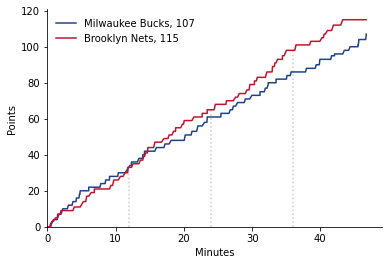

FG: 45 of 101 / 46 of 98
3P: 6 of 30 / 15 of 40
FT: 11 of 19 / 8 of 9
DRB: 43 of 49 / 41 of 56
AST: 21 / 25
STL: 4 / 7
BLK: 3 / 6
TOV: 14 / 8
PF: 15 / 21

Points:  G. Antetokounmpo 34, K. Durant 29, K. Irving 25
Rebounds:  B. Griffin 14, K. Middleton 13, G. Antetokounmpo 11
Assists:  K. Irving 8, J. Holiday 6, G. Antetokounmpo 4
Steals:  B. Griffin 2, P. Tucker 2, B. Portis 1
Blocks:  G. Antetokounmpo 2, K. Durant 2, B. Brown 2



In [8]:
plot_games_of_day(date.fromisoformat('2021-06-05'))

In [43]:
plot_games_of_day(date.fromisoformat('2021-06-06'))

KeyError: 'name'

In [40]:
import lorem

ModuleNotFoundError: No module named 'lorem'

In [10]:
pd.DataFrame(client.standings(2021))

,team,wins,losses,division,conference
0,Team.PHILADELPHIA_76ERS,49,23,Division.ATLANTIC,Conference.EASTERN
1,Team.BROOKLYN_NETS,48,24,Division.ATLANTIC,Conference.EASTERN
2,Team.NEW_YORK_KNICKS,41,31,Division.ATLANTIC,Conference.EASTERN
3,Team.BOSTON_CELTICS,36,36,Division.ATLANTIC,Conference.EASTERN
4,Team.TORONTO_RAPTORS,27,45,Division.ATLANTIC,Conference.EASTERN
5,Team.MILWAUKEE_BUCKS,46,26,Division.CENTRAL,Conference.EASTERN
6,Team.INDIANA_PACERS,34,38,Division.CENTRAL,Conference.EASTERN
7,Team.CHICAGO_BULLS,31,41,Division.CENTRAL,Conference.EASTERN
8,Team.CLEVELAND_CAVALIERS,22,50,Division.CENTRAL,Conference.EASTERN
9,Team.DETROIT_PISTONS,20,52,Division.CENTRAL,Conference.EASTERN


In [31]:
import matplotlib as mpl

In [ ]:
505 & 285

In [32]:
mpl.rcParams['figure.figsize'] = [5.05, 2.85]

[6.0, 4.0]

In [15]:
API.update_status?

Signature: API.update_status(*args, **kwargs)
Docstring:
:reference: https://developer.twitter.com/en/docs/tweets/post-and-engage/api-reference/post-statuses-update
:allowed_param: 'status', 'in_reply_to_status_id',
                'auto_populate_reply_metadata',
                'exclude_reply_user_ids', 'attachment_url',
                'media_ids', 'possibly_sensitive', 'lat', 'long',
                'place_id', 'display_coordinates', 'trim_user',
                'enable_dmcommands', 'fail_dmcommands', 'card_uri'
File:      c:\users\qiv\appdata\roaming\python\python38\site-packages\tweepy\api.py
Type:      method


In [12]:
import tweepy

In [37]:
date.today().day

6

In [7]:
import tweepy

In [8]:
### Authorization protocol
auth = tweepy.OAuthHandler(
    "7AnXmFZsZjJncN8DrxZDSUL6W", "VDb5qk5tOEE8CvKzQRg9SjiZAwzn3rgY3ztDo3otV1vluRUEqV"
)
auth.set_access_token(
    "3987567562-SDX0wqRZaSwx3tliWtkneGp1gJO3qolY0hWCmHO", "UTknI7guN5Sp0mAugznB30MJOjr1lzkwALzIM4lFBVLxx"
)

### Providing access to API 
API = tweepy.API(auth)
# api_reply = API.update_status(status="Hello World!")

In [9]:
API.search("from:PhGermann")

[]

In [34]:
if API.search(f"from:{API.me().screen_name} '#MILvsBRK 107:115 on 2021-06-05'\n"):
    print("Done")

Done


In [30]:
API.search("from:PhGermann 'harmonische statt kanonische'")

[]

In [32]:
API.me().screen_name

'NBA_Game_Plots'

In [28]:
auth = tweepy.OAuthHandler(
    "m2G34HwMeirnoM5uR0hkEif29", "oVrNgphq8nsBbfjWHXiUoUP3IRWG6mSnVb1agthVNBxZYV4etW"
)
auth.set_access_token(
    "1401611058318557190-JdHgfcg2wKEw5RIYGRc60u4RsRcWk5",
    "wgB7RKVd9KPaoPPGDOfFPgqE8HaXLuWdsnMLaAP2JlBCS",
)
API = tweepy.API(auth)

In [29]:
API.me()

User(_api=<tweepy.api.API object at 0x0000027493547E20>, _json={'id': 1401611058318557190, 'id_str': '1401611058318557190', 'name': 'NBA Game Plots', 'screen_name': 'NBA_Game_Plots', 'location': '', 'profile_location': None, 'description': "Because box scores don't tell the story. By @PhGermann.", 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 2, 'friends_count': 0, 'listed_count': 0, 'created_at': 'Sun Jun 06 18:45:12 +0000 2021', 'favourites_count': 0, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': False, 'statuses_count': 15, 'lang': None, 'status': {'created_at': 'Mon Jun 07 09:13:11 +0000 2021', 'id': 1401829581066285056, 'id_str': '1401829581066285056', 'text': 'Points: G. Antetokounmpo 34, K. Durant 29, K. Irving 25\nRebounds: B. Griffin 14, K. Middleton 13, G. Antetokounmpo… https://t.co/2ShTXaYWDC', 'truncated': True, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'http

In [21]:
api_reply.id_str

'1401591685721825288'

In [24]:
media = API.media_upload("descht.png")

In [26]:
API.create_media_metadata(media.media_id, "descht")

In [30]:
API.update_status("Link descht: https://www.basketball-reference.com/boxscores/pbp/202106040DAL.html", media_ids=[media.media_id])

TweepError: [{'code': 324, 'message': 'Invalid media status'}]

In [42]:
API.update_status(status="Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum."[:280])

Status(_api=<tweepy.api.API object at 0x000002B9FFC4ECD0>, _json={'created_at': 'Sun Jun 06 19:21:50 +0000 2021', 'id': 1401620366708154368, 'id_str': '1401620366708154368', 'text': "Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's stan… https://t.co/WAZM7yNcrl", 'truncated': True, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/WAZM7yNcrl', 'expanded_url': 'https://twitter.com/i/web/status/1401620366708154368', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]}, 'source': '<a href="https://help.twitter.com/en/using-twitter/how-to-tweet#source-labels" rel="nofollow">nba_game_plots</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 3987567562, 'id_str': '3987567562', 'name': 'Philipp Germann', 'screen_name': 'PhGermann', 'location

In [49]:
date_ = date.today()

In [56]:
date_ -= timedelta(days=7)
date_

datetime.date(2021, 5, 29)

In [11]:
import datetime
import time

In [5]:
datetime.datetime.now()

datetime.datetime(2021, 6, 8, 10, 12, 24, 835980)

In [12]:
API.update_status("Hello, world!")
while True:
    if not API.search(f"from:{API.me().screen_name} 'Hello, world!'"):
        print(datetime.datetime.now())
        time.sleep(1)
        continue
    break

2021-06-08 10:17:10.337823
2021-06-08 10:17:11.715703
2021-06-08 10:17:13.093047
2021-06-08 10:17:14.492297
2021-06-08 10:17:15.876800
2021-06-08 10:17:17.254746
2021-06-08 10:17:18.636528
2021-06-08 10:17:20.067273
2021-06-08 10:17:21.456173
2021-06-08 10:17:22.831296
2021-06-08 10:17:24.234960
2021-06-08 10:17:25.609077
2021-06-08 10:17:26.984849
2021-06-08 10:17:28.385240
2021-06-08 10:17:29.764281


In [10]:
API.me().screen_name

'PhGermann'

In [46]:
pd.DataFrame(
    client.player_box_scores(year=2021, month=6, day=5)
)

,slug,name,team,location,opponent,outcome,seconds_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,...,made_free_throws,attempted_free_throws,offensive_rebounds,defensive_rebounds,assists,steals,blocks,turnovers,personal_fouls,game_score
0,antetgi01,Giannis Antetokounmpo,Team.MILWAUKEE_BUCKS,Location.AWAY,Team.BROOKLYN_NETS,Outcome.LOSS,2115,16,24,2,...,0,3,0,11,4,0,2,5,3,23.7
1,irvinky01,Kyrie Irving,Team.BROOKLYN_NETS,Location.HOME,Team.MILWAUKEE_BUCKS,Outcome.WIN,2675,11,26,3,...,0,0,2,3,8,1,1,1,1,19.4
2,duranke01,Kevin Durant,Team.BROOKLYN_NETS,Location.HOME,Team.MILWAUKEE_BUCKS,Outcome.WIN,2406,12,25,1,...,4,4,1,9,3,1,2,3,5,19.2
3,lopezbr01,Brook Lopez,Team.MILWAUKEE_BUCKS,Location.AWAY,Team.BROOKLYN_NETS,Outcome.LOSS,1652,8,11,0,...,3,3,5,0,1,0,0,1,2,16.9
4,harrijo01,Joe Harris,Team.BROOKLYN_NETS,Location.HOME,Team.MILWAUKEE_BUCKS,Outcome.WIN,2058,7,11,5,...,0,0,0,2,2,1,0,1,0,16.1
5,griffbl01,Blake Griffin,Team.BROOKLYN_NETS,Location.HOME,Team.MILWAUKEE_BUCKS,Outcome.WIN,2103,7,13,4,...,0,0,2,12,3,2,0,3,6,15.4
6,holidjr01,Jrue Holiday,Team.MILWAUKEE_BUCKS,Location.AWAY,Team.BROOKLYN_NETS,Outcome.LOSS,2199,7,19,2,...,1,3,4,5,6,0,0,3,1,10.8
7,jamesmi02,Mike James,Team.BROOKLYN_NETS,Location.HOME,Team.MILWAUKEE_BUCKS,Outcome.WIN,1815,5,11,2,...,0,0,1,6,3,0,0,0,3,9.7
8,brownbr01,Bruce Brown,Team.BROOKLYN_NETS,Location.HOME,Team.MILWAUKEE_BUCKS,Outcome.WIN,1280,2,5,0,...,2,2,0,4,3,1,2,0,3,7.8
9,tuckepj01,P.J. Tucker,Team.MILWAUKEE_BUCKS,Location.AWAY,Team.BROOKLYN_NETS,Outcome.LOSS,1677,2,5,1,...,2,2,0,4,1,2,0,1,3,6.0


In [7]:
player_scores = pd.DataFrame(
    client.player_box_scores(year=2021, month=5, day=6)
)

In [8]:
len(player_scores)

152

In [7]:
for date_ in [date.today() + timedelta(days=i) for i in [-2, -1, 0]]:
    print(date_)

2021-06-05
2021-06-06
2021-06-07


In [ ]:
numpy==1.19.2
matplotlib==3.3.2
pandas==1.1.3
docopt==0.6.2
tweepy==3.10.0
seaborn==0.11.0
basketball_reference_web_scraper==4.12.0


In [8]:
import basketball_reference_web_scraper
basketball_reference_web_scraper.__version__

AttributeError: module 'basketball_reference_web_scraper' has no attribute '__version__'